# Notebook Imports

In [1]:
from os import walk
from os.path import join
import pandas as pd
import matplotlib.pyplot as plt

import nltk
from nltk.stem import PorterStemmer
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize

%matplotlib inline

# Constants

In [2]:
EXAMPLE_FILE = '/Users/brendan/Desktop/Python/Machine Learning - Spam Email/SpamData/01_Processing/practice_email.txt'
ROOT_FILE = '/Users/brendan/Desktop/Python/Machine Learning - Spam Email'

SPAM_1_PATH = ROOT_FILE+'/SpamData/01_Processing/spam_assassin_corpus/spam_1'
SPAM_2_PATH = ROOT_FILE+'/SpamData/01_Processing/spam_assassin_corpus/spam_2'
EASY_NONSPAM_1_PATH = ROOT_FILE+'/SpamData/01_Processing/spam_assassin_corpus/easy_ham_1'
EASY_NONSPAM_2_PATH = ROOT_FILE+'/SpamData/01_Processing/spam_assassin_corpus/easy_ham_2'

SPAM_CAT = 1
HAM_CAT = 0

DATA_JSON_FILE = ROOT_FILE+'/SpamData/01_Processing/email-text-data.json'

# Reading Files

In [3]:
stream = open(EXAMPLE_FILE, encoding='latin-1')
message = stream.read()
stream.close()

print(type(message))
print(message)

<class 'str'>
From exmh-workers-admin@redhat.com  Thu Aug 22 12:36:23 2002
Return-Path: <exmh-workers-admin@spamassassin.taint.org>
Delivered-To: zzzz@localhost.netnoteinc.com
Received: from localhost (localhost [127.0.0.1])
	by phobos.labs.netnoteinc.com (Postfix) with ESMTP id D03E543C36
	for <zzzz@localhost>; Thu, 22 Aug 2002 07:36:16 -0400 (EDT)
Received: from phobos [127.0.0.1]
	by localhost with IMAP (fetchmail-5.9.0)
	for zzzz@localhost (single-drop); Thu, 22 Aug 2002 12:36:16 +0100 (IST)
Received: from listman.spamassassin.taint.org (listman.spamassassin.taint.org [66.187.233.211]) by
    dogma.slashnull.org (8.11.6/8.11.6) with ESMTP id g7MBYrZ04811 for
    <zzzz-exmh@spamassassin.taint.org>; Thu, 22 Aug 2002 12:34:53 +0100
Received: from listman.spamassassin.taint.org (localhost.localdomain [127.0.0.1]) by
    listman.redhat.com (Postfix) with ESMTP id 8386540858; Thu, 22 Aug 2002
    07:35:02 -0400 (EDT)
Delivered-To: exmh-workers@listman.spamassassin.taint.org
Received: fro

In [4]:
import sys
sys.getfilesystemencoding()

'utf-8'

In [5]:
stream = open(EXAMPLE_FILE, encoding='latin-1')

is_body = False
lines = []

for line in stream:
    if is_body:
        lines.append(line)
    elif line == '\n':
        is_body = True

stream.close()

email_body = '\n'.join(lines)
print(email_body)




Dear Mr Still



Good tidings to you and all your staff for the festive season ahead (Christmas).

Now to the crux of the matter-in-hand: I am a fully qualified Santa Claus and am wondering whether you might consider me to run my own "Santa's Grotto" in your store.

But WAIT! You're probably thinking: "What makes him so special?"

Well, first of all, I have made several changes to the characterisation of Father Christmas. Rather than greeting the children with shouts of "Ho, ho, ho!" I prefer to whisper the phrase "Dependence is not unfathomable in this cruel world we live in". In addition, my gifts are ALL hand-made, ranging from felt hoops to vanilla-pod holders.

You will note also, from the enclosed sketch, that I have radically redesigned Santa's outfit and have renamed my character "Lord Buckles". Would you be interested in employing me? I promise NEVER to let you down.

I look forward to hearing from you.



Best wishes

Robin Cooper

[Excerpt from the book: The Timewaster Let

# Generator Functions

In [6]:
def generate_squares(N):
    for my_number in range(N):
        yield my_number ** 2

In [7]:
for i in generate_squares(3):
    print(i, end=' ->')

0 ->1 ->4 ->

In [8]:
for i in generate_squares(5):
    print(i, end=' ->')

0 ->1 ->4 ->9 ->16 ->

## Email body extraction

In [9]:
def email_body_generator(path):
    
    for root, dirnames, filenames in walk(path):
        for file_name in filenames:
            
            filepath = join(root, file_name)
            
            stream = open(filepath, encoding='latin-1')

            is_body = False
            lines = []

            for line in stream:
                if is_body:
                    lines.append(line)
                elif line == '\n':
                    is_body = True

            stream.close()

            email_body = '\n'.join(lines)
            
            yield file_name, email_body

In [10]:
def df_from_directory(path, classification):
    rows = []
    row_names = []
    
    for file_name, email_body in email_body_generator(path):
        rows.append({'MESSAGE': email_body, 'CATEGORY': classification})
        row_names.append(file_name)
    
    return pd.DataFrame(rows, index=row_names)

In [11]:
spam_emails = df_from_directory(SPAM_1_PATH, 1)
spam_emails = spam_emails.append(df_from_directory(SPAM_2_PATH,1))
spam_emails.head()

,MESSAGE,CATEGORY
00249.5f45607c1bffe89f60ba1ec9f878039a,"Dear Homeowner,\n\n \n\nInterest Rates are at ...",1
00373.ebe8670ac56b04125c25100a36ab0510,ATTENTION: This is a MUST for ALL Computer Use...,1
00214.1367039e50dc6b7adb0f2aa8aba83216,This is a multi-part message in MIME format.\n...,1
00210.050ffd105bd4e006771ee63cabc59978,IMPORTANT INFORMATION:\n\n\n\nThe new domain n...,1
00033.9babb58d9298daa2963d4f514193d7d6,This is the bottom line. If you can GIVE AWAY...,1


In [12]:
spam_emails.shape

(1898, 2)

In [13]:
ham_emails = df_from_directory(EASY_NONSPAM_1_PATH,HAM_CAT)
ham_emails = ham_emails.append(df_from_directory(EASY_NONSPAM_2_PATH,HAM_CAT))
ham_emails.head(), ham_emails.shape

(                                                                                  MESSAGE  \
 00769.25bf9a767b5db0ed93f03c1637281663  \n\nIn a message dated 9/24/2002 11:24:58 AM, ...   
 01074.8590d61ac0aeeadb58dc2f2ba776c406  Hiya, I always seem to get errors when I do an...   
 02479.14365bcad3a60fcf24c5c1813f6291fb  \n\nI don't know how one can expect better and...   
 01417.ce7b07a2114218dbac682b599785820d  Tim Peters wrote:\n\n> I've run no experiments...   
 00357.d559b71616f64ba1d1c1e61a03644fd4  At 10:34 AM -0700 on 8/28/02, Jim Whitehead wr...   
 
                                         CATEGORY  
 00769.25bf9a767b5db0ed93f03c1637281663         0  
 01074.8590d61ac0aeeadb58dc2f2ba776c406         0  
 02479.14365bcad3a60fcf24c5c1813f6291fb         0  
 01417.ce7b07a2114218dbac682b599785820d         0  
 00357.d559b71616f64ba1d1c1e61a03644fd4         0  ,
 (3901, 2))

In [14]:
data = pd.concat([spam_emails, ham_emails])
print('SHape of entire dataframe is ', data.shape)
data.head()

SHape of entire dataframe is  (5799, 2)


,MESSAGE,CATEGORY
00249.5f45607c1bffe89f60ba1ec9f878039a,"Dear Homeowner,\n\n \n\nInterest Rates are at ...",1
00373.ebe8670ac56b04125c25100a36ab0510,ATTENTION: This is a MUST for ALL Computer Use...,1
00214.1367039e50dc6b7adb0f2aa8aba83216,This is a multi-part message in MIME format.\n...,1
00210.050ffd105bd4e006771ee63cabc59978,IMPORTANT INFORMATION:\n\n\n\nThe new domain n...,1
00033.9babb58d9298daa2963d4f514193d7d6,This is the bottom line. If you can GIVE AWAY...,1


In [15]:
data.tail()

,MESSAGE,CATEGORY
00609.dd49926ce94a1ea328cce9b62825bc97,"I'm one of the 30,000 but it's not working ver...",0
00957.e0b56b117f3ec5f85e432a9d2a47801f,Damien Morton quoted:\n\n>W3C approves HTML 4 ...,0
01127.841233b48eceb74a825417d8d918abf8,"On Mon, 2002-07-22 at 06:50, che wrote:\n\n\n\...",0
01178.5c977dff972cd6eef64d4173b90307f0,"Once upon a time, Manfred wrote :\n\n\n\n> I w...",0
00747.352d424267d36975a7b40b85ffd0885e,"If you run Pick, and then use the ""New FTOC"" b...",0


# Data Cleaning: Checking for Missing Values

In [16]:
# check if any message bodies are null
data['MESSAGE'].isnull().values.any()

False

In [17]:
len("")

0

In [18]:
type("")

str

In [19]:
my_var = None

In [20]:
type(my_var)

NoneType

In [21]:
# check if there are empty email (string length zero)
(data['MESSAGE'].str.len() == 0).any()

True

In [22]:
(data['MESSAGE'].str.len() == 0).sum()

3

In [23]:
# challenge: how to check the # of entries
data['MESSAGE'].isnull().sum()

0

## Locate empty emails

In [24]:
type(data['MESSAGE'].str.len() == 0)

pandas.core.series.Series

In [25]:
data[data['MESSAGE'].str.len() ==0].index



Index(['cmds', 'cmds', 'cmds'], dtype='object')

In [26]:
data.index.get_loc('cmds')

array([False, False, False, ..., False, False, False])

In [27]:
data[4608:4611]

,MESSAGE,CATEGORY
01121.d3a6706a1a5c4c927c4cc7a038367f62,"On August 7th, an entity known as ""iDEFENSE"" s...",0
01293.1bfec3fa6ca7c5fbc5bd7ffdfe2c2780,O'Reilly Open Source Convention\n\n-From the F...,0
00978.6ee6ee70e9126bba327faa762d37b3f9,Has anyone had much positive experience with P...,0


# Remove System File Entries from Dataframe

In [28]:
data.shape

(5799, 2)

# Add Document IDs to Track Emails in Dataset

In [29]:
document_ids = range(0, len(data.index))
data['DOC_ID'] = document_ids

In [30]:
data['FILE_NAME'] = data.index
data.set_index('DOC_ID', inplace=True)
data.head()

,MESSAGE,CATEGORY,FILE_NAME
DOC_ID,,,
0,"Dear Homeowner,\n\n \n\nInterest Rates are at ...",1,00249.5f45607c1bffe89f60ba1ec9f878039a
1,ATTENTION: This is a MUST for ALL Computer Use...,1,00373.ebe8670ac56b04125c25100a36ab0510
2,This is a multi-part message in MIME format.\n...,1,00214.1367039e50dc6b7adb0f2aa8aba83216
3,IMPORTANT INFORMATION:\n\n\n\nThe new domain n...,1,00210.050ffd105bd4e006771ee63cabc59978
4,This is the bottom line. If you can GIVE AWAY...,1,00033.9babb58d9298daa2963d4f514193d7d6


# Save to File using Pandas

In [31]:
data.to_json(DATA_JSON_FILE)

# Number of Spam Mssages Visualized

In [32]:
data['CATEGORY'].value_counts()

0    3901
1    1898
Name: CATEGORY, dtype: int64

In [33]:
amount_of_spam = data['CATEGORY'].value_counts()[1]
amount_of_ham = data['CATEGORY'].value_counts()[0]

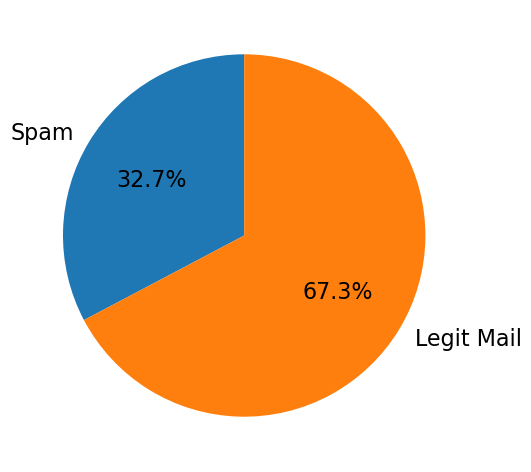

In [34]:
category_names = ['Spam', 'Legit Mail']
sizes = [amount_of_spam, amount_of_ham]

plt.figure(figsize=(6,6), dpi=100)
plt.pie(sizes, labels=category_names, textprops={'fontsize':16}, startangle=90, autopct='%1.1f%%')
plt.show()

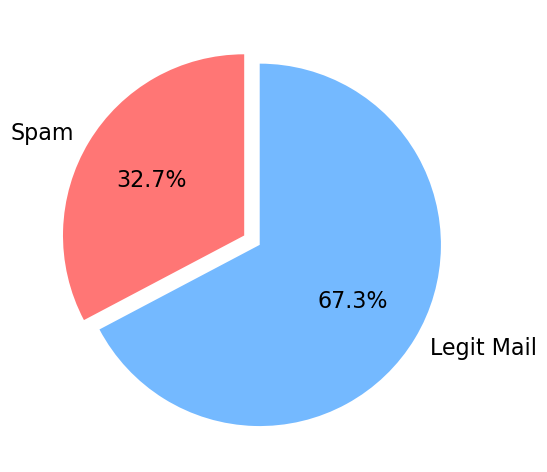

In [35]:
category_names = ['Spam', 'Legit Mail']
sizes = [amount_of_spam, amount_of_ham]
custom_colors = ['#ff7675','#74b9ff']

plt.figure(figsize=(6,6), dpi=100)
plt.pie(sizes, labels=category_names, textprops={'fontsize':16}, startangle=90, autopct='%1.1f%%',
       colors=custom_colors, explode=[0, 0.1])
plt.show()

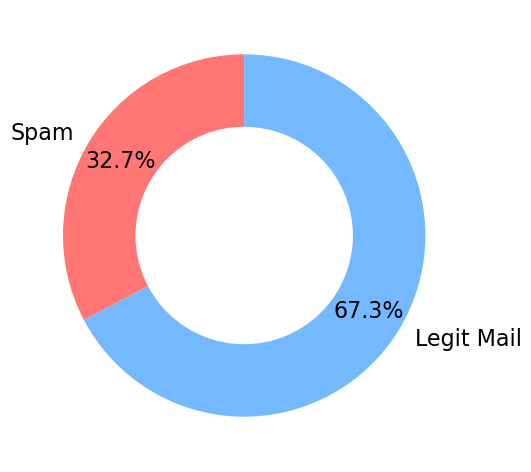

In [36]:
category_names = ['Spam', 'Legit Mail']
sizes = [amount_of_spam, amount_of_ham]
custom_colors = ['#ff7675','#74b9ff']

plt.figure(figsize=(6,6), dpi=100)
plt.pie(sizes, labels=category_names, textprops={'fontsize':16}, startangle=90, autopct='%1.1f%%',
       colors=custom_colors, pctdistance=0.8)

# draw circle
center_circle = plt.Circle((0,0), radius=0.6, fc='white')
plt.gca().add_artist(center_circle)

plt.show()

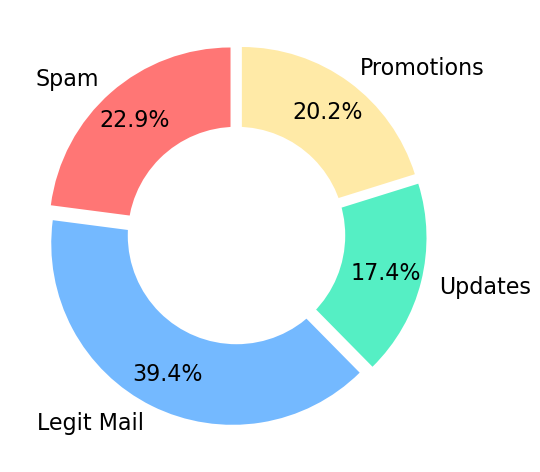

In [37]:
category_names = ['Spam', 'Legit Mail', 'Updates', 'Promotions']
sizes = [25,43,19,22]
custom_colors = ['#ff7675','#74b9ff', '#55efc4', '#ffeaa7']
offset = [0.05, 0.05, 0.05, 0.05]

plt.figure(figsize=(6,6), dpi=100)
plt.pie(sizes, labels=category_names, textprops={'fontsize':16}, startangle=90, autopct='%1.1f%%',
       colors=custom_colors, pctdistance=0.8, explode=offset)

# draw circle
center_circle = plt.Circle((0,0), radius=0.6, fc='white')
plt.gca().add_artist(center_circle)

plt.show()

# Natural Language Processing

### Text Pre-processing

In [38]:
# convert to lower case
msg = 'All work and no play makes Jack a dull boy.'
msg = msg.lower()
msg

'all work and no play makes jack a dull boy.'

### Download the NLTK Resources (Tokenizer * Stopwords)

In [39]:
nltk.download('punkt')

[nltk_data] Downloading package punkt to /Users/brendan/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.


True

In [42]:
nltk.download('stopwords')

[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/brendan/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


True

## Tokenizing

In [41]:
msg = 'All work and no play makes Jack a dull boy.'
word_tokenize(msg.lower())

['all', 'work', 'and', 'no', 'play', 'makes', 'jack', 'a', 'dull', 'boy', '.']

## Removing Stop Words

In [44]:
stopwords.words('english'), type(stopwords.words('english'))

(['i',
  'me',
  'my',
  'myself',
  'we',
  'our',
  'ours',
  'ourselves',
  'you',
  "you're",
  "you've",
  "you'll",
  "you'd",
  'your',
  'yours',
  'yourself',
  'yourselves',
  'he',
  'him',
  'his',
  'himself',
  'she',
  "she's",
  'her',
  'hers',
  'herself',
  'it',
  "it's",
  'its',
  'itself',
  'they',
  'them',
  'their',
  'theirs',
  'themselves',
  'what',
  'which',
  'who',
  'whom',
  'this',
  'that',
  "that'll",
  'these',
  'those',
  'am',
  'is',
  'are',
  'was',
  'were',
  'be',
  'been',
  'being',
  'have',
  'has',
  'had',
  'having',
  'do',
  'does',
  'did',
  'doing',
  'a',
  'an',
  'the',
  'and',
  'but',
  'if',
  'or',
  'because',
  'as',
  'until',
  'while',
  'of',
  'at',
  'by',
  'for',
  'with',
  'about',
  'against',
  'between',
  'into',
  'through',
  'during',
  'before',
  'after',
  'above',
  'below',
  'to',
  'from',
  'up',
  'down',
  'in',
  'out',
  'on',
  'off',
  'over',
  'under',
  'again',
  'further',
  'th

In [46]:
stop_words = set(stopwords.words('english'))

In [47]:
type(stop_words)

set

In [48]:
if 'this' in stop_words: print('Found it!')

Found it!


In [49]:
if 'hello' in stop_words: print('Found it!')

In [51]:
# print out Nope not in Here if the word not contain in stop words
if 'hello' not in stop_words: print('Nope. Not in here')

Nope. Not in here


In [53]:
msg = 'All work and no play makes Jack a dull boy. To be or not to be'
words = word_tokenize(msg.lower())

filtered_words = []

for word in words:
    if word not in stop_words:
        filtered_words.append(word)
print(filtered_words)


['work', 'play', 'makes', 'jack', 'dull', 'boy', '.']
